In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

## Dataset
- URL: [Covid-19 Image Dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset)
- Description: Folders split into `**train**` and `**test**`; each contains three more folder (`Covid`, `Normal`, `Pneumonia`)
- Task: Multi-class classification since three classes appear
- Important information: 1 input channel since X-rays are in greyscale.

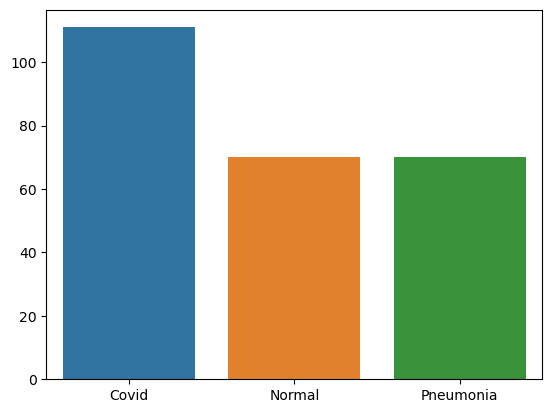

In [6]:
covid = len([filename for filename in os.listdir('Covid19-dataset/train/Covid/')])
normal = len([filename for filename in os.listdir('Covid19-dataset/train/Normal/')])
pneumonia = len([filename for filename in os.listdir('Covid19-dataset/train/Pneumonia/')])
labels = ['Covid', 'Normal', 'Pneumonia']
values = [covid, normal, pneumonia]

sns.barplot(x=labels, y=values, hue=labels)
plt.show()

In [7]:
BATCH_SIZE = 8

train_data_generator = ImageDataGenerator(
    rescale=1./255, # rescale pixes from [0, 255] to [0,1] (better for cnns)
    rotation_range=40, # rotate images up to 40 degrees
    width_shift_range=0.2, # shift the image horizontally by up to 20% of the width
    height_shift_range=0.2, # shift the image vertically by up to 20% of the height
    shear_range=0.2, # image will be distorted along an axis, to create or rectify the perception angles
    zoom_range=0.2, # zoom in or out by up to 20%
    horizontal_flip=True, # randomly flip half of the images horizontally
    fill_mode='nearest', # fill in newly created pixels, with the most common one
    validation_split=0.2,  # 20% of the data will be used for validation
    brightness_range=[0.8, 1.2],  # Add brightness adjustment
    channel_shift_range=0.2  # Add channel shift
)

# Define the data generator for the test data (no augmentation, only rescaling)
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

# Create the training data iterator
train_data_iter = train_data_generator.flow_from_directory(
    directory="Covid19-dataset/train/",
    class_mode='categorical',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    seed=42,
    subset='training'  # Use subset='training' for training data
)

# Create the validation data iterator
validation_data_iter = train_data_generator.flow_from_directory(
    directory="Covid19-dataset/train/",
    class_mode='categorical',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    seed=42,
    subset='validation'  # Use subset='validation' for validation data
)

# Create the test data iterator
test_data_iter = test_data_generator.flow_from_directory(
    directory="Covid19-dataset/test/",
    class_mode='categorical',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    seed=42
)

# Fetch a batch of data to verify
sample_batch_train_inp, sample_batch_train_labels = next(train_data_iter)
sample_batch_val_inp, sample_batch_val_labels = next(validation_data_iter)
sample_batch_test_inp, sample_batch_test_labels = next(test_data_iter)

print("\nTrain data:")
print(sample_batch_train_inp.shape, sample_batch_train_labels.shape, "\n")
print("\nValidation data:")
print(sample_batch_val_inp.shape, sample_batch_val_labels.shape, "\n")
print("\nTest data:")
print(sample_batch_test_inp.shape, sample_batch_test_labels.shape, "\n")

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.

Train data:
(8, 256, 256, 1) (8, 3) 


Validation data:
(8, 256, 256, 1) (8, 3) 


Test data:
(8, 256, 256, 1) (8, 3) 



Verification of the numbers we see:
- for both the train and test we should have `5` as the first number in the tuple (i.e., BATCH_SIZE)
- for both the train and test set the `target_size` (height, width) of the images should be `(256, 256)`
- for both the train the test set the `input_channel` should equal to 1, because images are grayscale X-rays.
- the classes should be `3` (`Normal`, `Covid 19`, `Pneumonia`)

In [8]:
base_model = VGG16(input_shape=(256, 256, 1), include_top=False, weights=None)
base_model.layers[0]._batch_input_shape = (None, 256, 256, 1)

model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(model.summary())

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,713,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,713,536 (56.13 MB)

 Trainable params: 14,713,536 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
class TestLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data_iter):
        self.test_data_iter = test_data_iter
        self.test_losses = []
        self.test_accuracies = []
        self.test_aucs = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy, test_auc = self.model.evaluate(self.test_data_iter, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        self.test_aucs.append(test_auc)
        print(f'\nTest loss after epoch {epoch + 1}: {test_loss:.4f}')

test_loss_callback = TestLossCallback(test_data_iter)

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20))

history = model.fit(
    train_data_iter,
    validation_data=validation_data_iter,
    epochs=200,
    callbacks=[test_loss_callback, early_stopping, lr_scheduler]
)

test_loss, test_accuracy, test_auc = model.evaluate(test_data_iter)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

Epoch 1/200
 9/26 ━━━━━━━━━━━━━━━━━━━━ 1:44 6s/step - auc: 0.5727 - categorical_accuracy: 0.4711 - loss: 1.0874 - precision: 0.1574 - recall: 0.0214  

In [82]:
# save model for external use
# https://www.tensorflow.org/tutorials/keras/save_and_load
os.makedirs('model/', exist_ok=True)
model.save('model/seq_cnn_pneu.keras')

# in case you want to load it and use it
# loaded_model = tf.keras.models.load_model('model/seq_cnn_pneu.keras')

In [83]:
print(history.history.keys())

dict_keys(['auc', 'categorical_accuracy', 'loss', 'val_auc', 'val_categorical_accuracy', 'val_loss'])


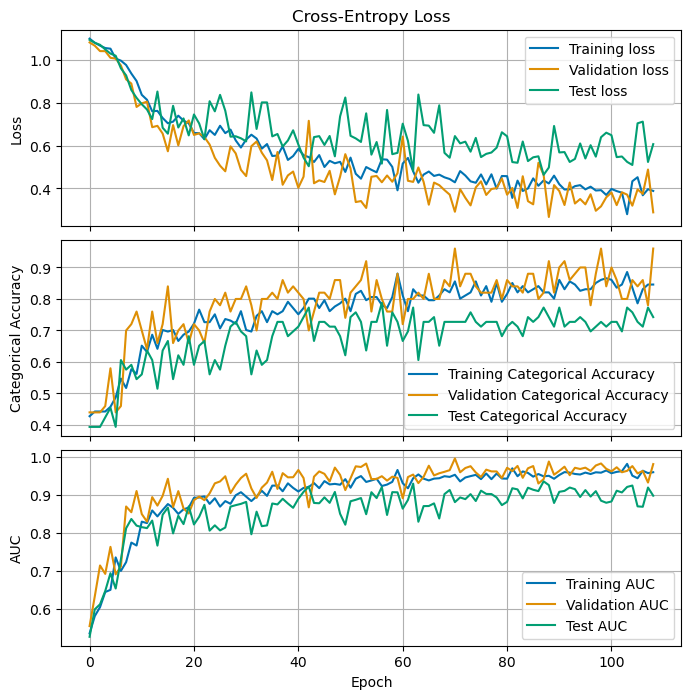

In [90]:
# Update the plotting code to include test loss
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True, squeeze=True)
fig.subplots_adjust(hspace=0.07, wspace=-0.8)

# Plot training and validation loss
axs[0].plot(history.history['loss'], label='Training loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].plot(test_loss_callback.test_losses, label='Test loss')
axs[0].set_title("Cross-Entropy Loss")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

# Plot training and validation accuracy
axs[1].plot(history.history['categorical_accuracy'], label='Training Categorical Accuracy')
axs[1].plot(history.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
axs[1].plot(test_loss_callback.test_accuracies, label='Test Categorical Accuracy')
axs[1].set_ylabel("Categorical Accuracy")
axs[1].legend()
axs[1].grid()

# Plot training and validation AUC
axs[2].plot(history.history['auc'], label='Training AUC')
axs[2].plot(history.history['val_auc'], label='Validation AUC')
axs[2].plot(test_loss_callback.test_aucs, label='Test AUC')
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("AUC")
axs[2].legend()
axs[2].grid()

os.makedirs('plots/', exist_ok=True)
outp_dir = 'plots/'
plt.savefig(os.path.join(outp_dir, 'performance_plots.jpeg'), dpi=500)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pneumonia_Type_0
	Model prediction: [0.00426678 0.04738879 0.94834435]
	True label: Covid (0)
	Correct: False


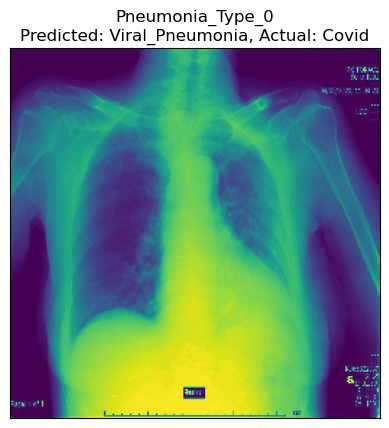

<Figure size 640x480 with 0 Axes>

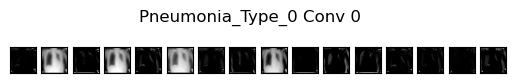

<Figure size 640x480 with 0 Axes>

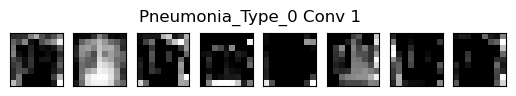

<Figure size 640x480 with 0 Axes>

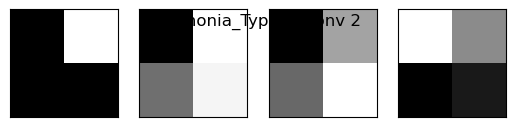

Pneumonia_Type_1
	Model prediction: [0.06555244 0.12426161 0.81018597]
	True label: Covid (0)
	Correct: False


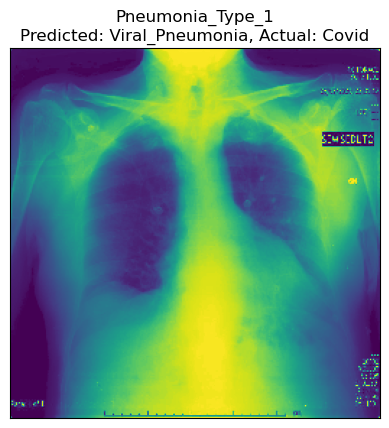

<Figure size 640x480 with 0 Axes>

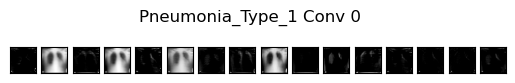

<Figure size 640x480 with 0 Axes>

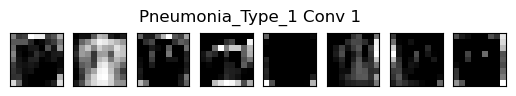

<Figure size 640x480 with 0 Axes>

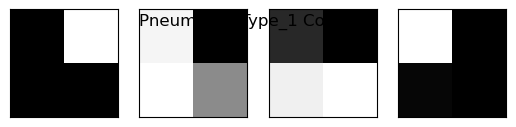

Pneumonia_Type_2
	Model prediction: [0.0252457 0.4153879 0.5593664]
	True label: Viral_Pneumonia (2)
	Correct: True


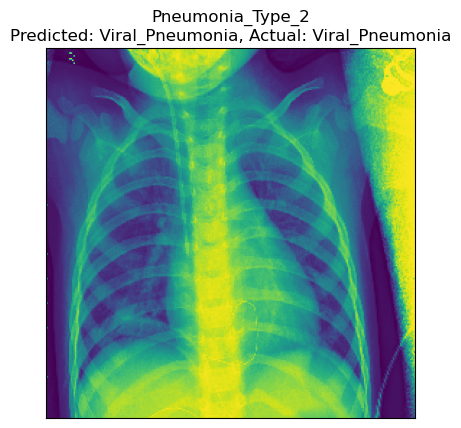

<Figure size 640x480 with 0 Axes>

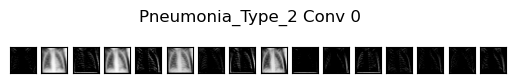

<Figure size 640x480 with 0 Axes>

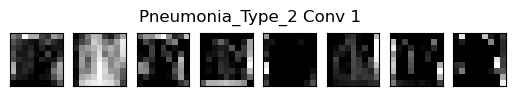

<Figure size 640x480 with 0 Axes>

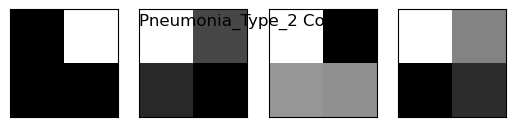

Pneumonia_Type_3
	Model prediction: [0.01655775 0.54495084 0.43849143]
	True label: Normal (1)
	Correct: True


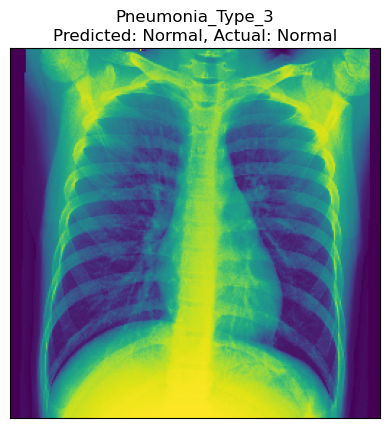

<Figure size 640x480 with 0 Axes>

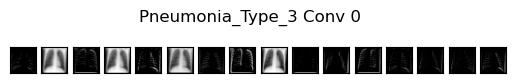

<Figure size 640x480 with 0 Axes>

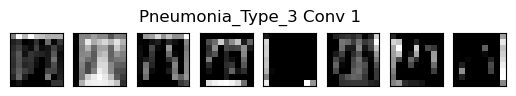

<Figure size 640x480 with 0 Axes>

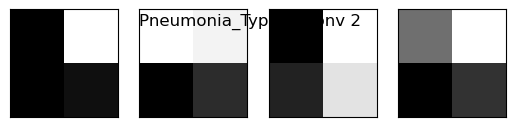

<Figure size 640x480 with 0 Axes>

In [85]:
from vis_feat_maps import visualize_activations

visualize_activations(model, 
                      validation_iterator=test_data_iter, 
                      class_names = {0:"Covid",1:"Normal",2:"Viral_Pneumonia"},
                      number_of_imgs = 6)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

       Covid       0.33      0.27      0.30        26
      Normal       0.25      0.10      0.14        20
   Pneumonia       0.30      0.55      0.39        20

    accuracy                           0.30        66
   macro avg       0.29      0.31      0.28        66
weighted avg       0.30      0.30      0.28        66

[[ 7  3 16]
 [ 8  2 10]
 [ 6  3 11]]


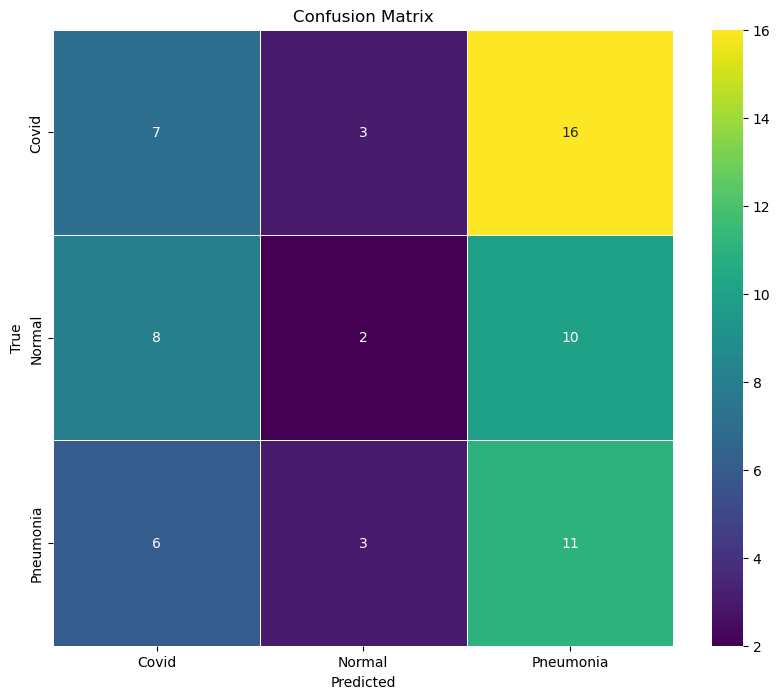

In [86]:
import math
import numpy as np
import seaborn as sns

sns.set_palette('colorblind')
test_steps_per_epoch = math.ceil(test_data_iter.samples / test_data_iter.batch_size)
predictions = model.predict(test_data_iter, steps=test_steps_per_epoch)
test_steps_per_epoch = math.ceil(test_data_iter.samples / test_data_iter.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_iter.classes
class_labels = list(test_data_iter.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            cmap='viridis',
            linewidths=.5,
            xticklabels=class_labels, yticklabels=class_labels,)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()